In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()

In [7]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# find last datapoint in the database by date
last_date = session.query(Measurement.date).order_by((Measurement.date).desc()).limit(5).all()
last_date

[('2017-08-23'),
 ('2017-08-23'),
 ('2017-08-23'),
 ('2017-08-23'),
 ('2017-08-22')]

In [12]:
# find one year prior to last date
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [13]:
# Perform a query to retrieve the data (is this supposed to be "date"???) and precipitation scores
date_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df = pd.DataFrame(date_prcp)
date_prcp_df = date_prcp_df.set_index('date')
date_prcp_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [15]:
# Sort the dataframe by date
date_prcp_df = date_prcp_df.sort_values('date')
date_prcp_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


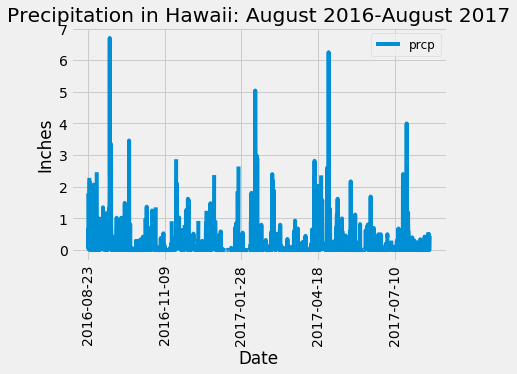

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
# figure out legend

date_prcp_df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(fontsize="12")
plt.title("Precipitation in Hawaii: August 2016-August 2017")
plt.show();

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset.
num_stations = session.query(Station.station).count()
print(f"This dataset contains {num_stations} stations.")

This dataset contains 9 stations.


In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).limit(1).all()
count_stations[0][0]
# print(f"The most active station is {count_stations[0][0]} with {count_stations[0][1]} counts.")

'USC00519281'

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
low_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
mean_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(f"The lowest temperature recorded for station {count_stations[0][0]} is {low_temp[0]}.")
print(f"The higest temperature recorded for station {count_stations[0][0]} is {high_temp[0]}.")
print(f"The mean temperature recorded for station {count_stations[0][0]} is {mean_temp[0]}.")

The lowest temperature recorded for station USC00519281 is (54.0,).
The higest temperature recorded for station USC00519281 is (85.0,).
The mean temperature recorded for station USC00519281 is (71.66378066378067,).


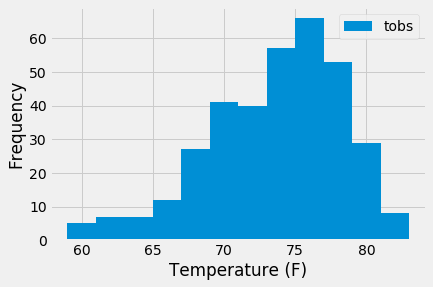

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= one_year_ago).all()
temp_obs_df = pd.DataFrame(temp_obs)
temp_obs_df.plot(kind="hist", bins=12)
plt.xlabel("Temperature (F)")
plt.show();

## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


In [43]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = 75-61
avg_temp = 69.57
x_axis = (range(len(avg_temp))
plt.bar(x-axis, avg_temp, yerr=yerr, color='r', alpha=0.5)
plt.show()

SyntaxError: invalid syntax (<ipython-input-43-116a75aafddc>, line 8)

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
